In [1]:
import numpy as np
import pandas as pd
import math

from sklearn.preprocessing import StandardScaler
from sklearn.mixture import GaussianMixture

import scipy, scipy.stats

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# für interactive Plots in jupyter notebooks
# %matplotlib notebook

# Clustering der Bank Daten mittels dem RFM Modell

Einlesen der Bankdaten und da wir die Attribute 'gender', 'merchant', 'category','age' in diesem Beispiel nicht brauchen verwerfen wir sie direkt

In [2]:
file_name = '~/neuefische/data-fish/data/bank_transactions.csv'
data = pd.read_csv(file_name) 

In [3]:
data.drop(['gender', 'merchant', 'category','age'], axis=1, inplace=True)

In [4]:
data.head()

,step,customer,amount,fraud
0,0,C1093826151,4.55,0
1,0,C352968107,39.68,0
2,0,C2054744914,26.89,0
3,0,C1760612790,17.25,0
4,0,C757503768,35.72,0


In [5]:
mean_values = data.groupby('customer').mean().drop(['step'], axis=1)
fraud_values = data.groupby('customer').sum().drop(['step','amount'], axis=1).rename(index=str, columns={"fraud": "fraud_absolute"})
max_values = data.groupby('customer').max().drop(['amount', 'fraud'], axis=1).rename(index=str, columns={"step": "recency"})
count_values = data.groupby('customer').count().drop(['amount', 'fraud'], axis=1).rename(index=str, columns={"step": "frequency"})

In [6]:
rfm_data = pd.concat([mean_values, max_values, count_values, fraud_values], axis=1, sort=False)
rfm_data['recency'] = 179 - rfm_data['recency']

---

## Wie sehen die Daten aus?

In [7]:
rfm_data.describe()

,amount,fraud,recency,frequency,fraud_absolute
count,4112.000000,4112.000000,4112.000000,4112.000000,4112.000000
mean,45.335268,0.023469,0.996352,144.611625,1.750973
std,48.922168,0.081532,5.032102,42.788212,7.053622
min,23.372024,0.000000,0.000000,5.000000,0.000000
25%,30.215169,0.000000,0.000000,130.000000,0.000000
50%,32.631427,0.000000,0.000000,165.000000,0.000000
75%,38.249849,0.012987,0.000000,173.000000,2.000000
max,838.158333,0.945652,105.000000,265.000000,144.000000


**Wie sind die Daten verteilt?**

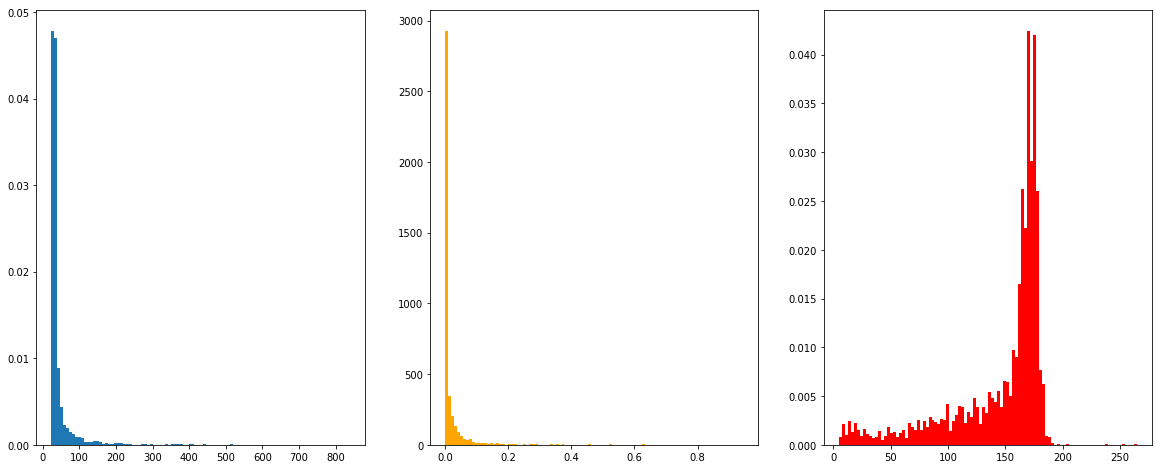

In [8]:
plt.figure(1, figsize=(20, 8))

plt.subplot(1,3, 1 )
plt.hist(rfm_data['amount'], bins=100, density=True)

plt.subplot(1,3, 2 )
plt.hist(rfm_data['fraud'], bins=100, color='orange')

plt.subplot(1,3, 3 )
plt.hist(rfm_data['frequency'], bins=100, density=True,color='red')


plt.show()

In [9]:
mean = 144.611625
std = 42.788212

In [10]:
lower = scipy.stats.norm.ppf(0.001,mean,std)
upper = scipy.stats.norm.ppf(0.999,mean,std)
x = scipy.linspace(lower,upper,100)

In [11]:
y = scipy.stats.norm.pdf(x,mean,std)

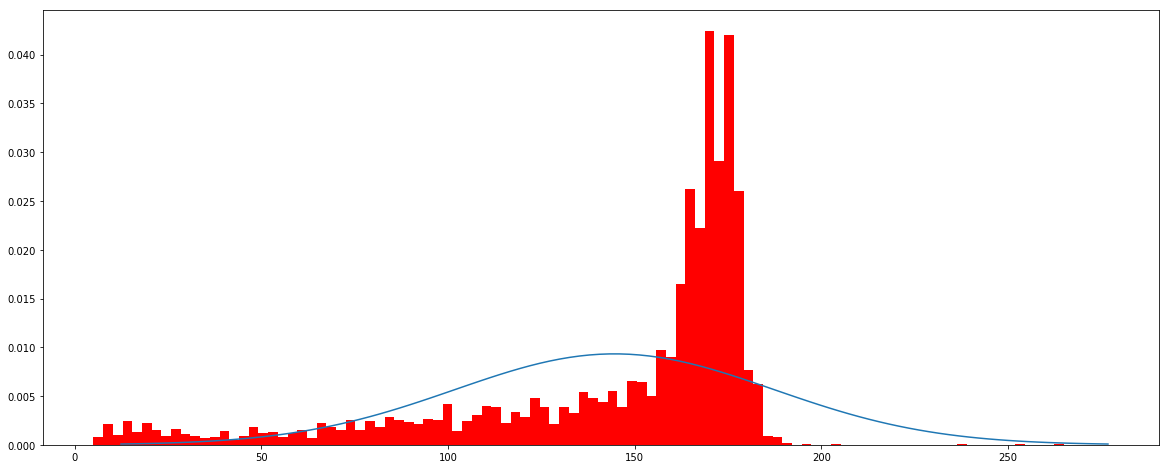

In [12]:
plt.figure(1,figsize=(20, 8))
plt.hist(rfm_data['frequency'], bins=100, density=True,color='red')
plt.plot(x,y);

In [13]:
gmm = GaussianMixture(2)

In [14]:
gmm.fit(rfm_data[['frequency']])

GaussianMixture(covariance_type='full', init_params='kmeans', max_iter=100,
        means_init=None, n_components=2, n_init=1, precisions_init=None,
        random_state=None, reg_covar=1e-06, tol=0.001, verbose=0,
        verbose_interval=10, warm_start=False, weights_init=None)

In [15]:
rfm_data['gmm_freq_cluster'] = gmm.predict(rfm_data[['frequency']])

In [16]:
gmm.means_

array([[106.90047672],
       [170.32083477]])

In [17]:
gmm.covariances_

array([[[2059.22504283]],

       [[  43.88968701]]])

In [18]:
std_1 = math.sqrt(gmm.covariances_[0][0])
mean_1 = gmm.means_[0][0]

lower_1 = scipy.stats.norm.ppf(0.001,mean_1,std_1)
upper_1 = scipy.stats.norm.ppf(0.999,mean_1,std_1)
x_1 = scipy.linspace(lower_1,upper_1,100)
y_1 = scipy.stats.norm.pdf(x_1,mean_1,std_1)

In [19]:
std_2 = math.sqrt(gmm.covariances_[1])
mean_2 = gmm.means_[1]
lower_2 = scipy.stats.norm.ppf(0.001,mean_2,std_2)
upper_2 = scipy.stats.norm.ppf(0.999,mean_2,std_2)
x_2 = scipy.linspace(lower_2,upper_2,100)
y_2 = scipy.stats.norm.pdf(x_2,mean_2,std_2)

In [21]:
x_3 = scipy.linspace(lower_1,upper_2,100)
y_3 = scipy.stats.norm.pdf(x_3,mean_1,std_1) + scipy.stats.norm.pdf(x_3,mean_2,std_2)

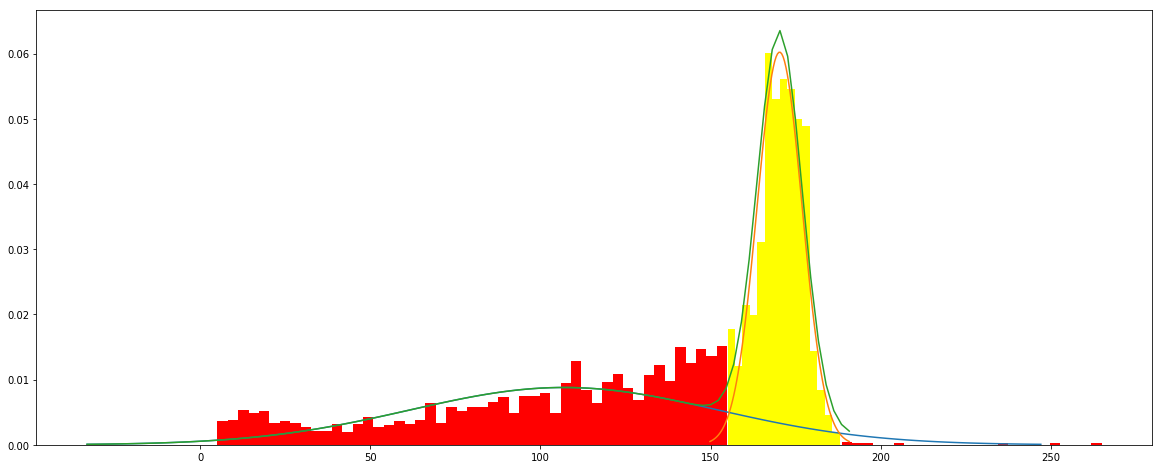

In [23]:
color_map = ['red', 'yellow', 'green']
plt.figure(1,figsize=(20, 8))
plt.hist(rfm_data[rfm_data['gmm_freq_cluster'] == 0]['frequency'], bins=85, density=True, color='red')
plt.hist(rfm_data[rfm_data['gmm_freq_cluster'] == 1]['frequency'], bins=15, density=True, color='yellow')
plt.plot(x_1,y_1);
plt.plot(x_2,y_2);
plt.plot(x_3,y_3);
# alternative die zwei Funktionen übernander zu legen
#y_2_new = np.interp(x_1,x_2,y_2)
#plt.plot(x_1,y_1+y_2_new);

## Gaussian Mixture Models

**Daten normalisieren**

In [ ]:
rfm_data_scaled = StandardScaler().fit_transform(rfm_data[['recency', 'frequency', 'amount']])

**Clustern**

In [ ]:
gmm = GaussianMixture(5)

In [ ]:
gmm.fit(rfm_data_scaled)

In [ ]:
rfm_data['gmm_cluster'] = gmm.predict(rfm_data_scaled)

In [ ]:
%matplotlib notebook
fig = plt.figure().gca(projection='3d')
fig.set_xlabel('recency')
fig.set_ylabel('frequency')
fig.set_zlabel('amount')
fig.scatter(rfm_data['recency'], rfm_data['frequency'], rfm_data['amount'], c=rfm_data['gmm_cluster']);

---